In [160]:
import pandas as pd
import geopandas as gpd
import glob
import gc
import os
from shapely import wkt
from matplotlib import pyplot as plt

# 1. korea territory File processing

## 1-1. 도 경계

## 1-2. 시군구 경계

## 1-3. 법정동 경계

1. zip file to csv

In [161]:
for file_path in glob.glob("../dataset/*.zip"):
    # Shape 파일을 GeoDataFrame으로 불러오기
    gdf = gpd.GeoDataFrame.from_file(file_path, encoding='CP949')
    base_name = os.path.basename(file_path).split('.')[0]  # get absolute file path

    # 경위도 좌표계 설정
    gdf = gdf.to_crs({"init": "epsg:4326"})
    # CSV로 저장할 파일명
    gdf.info()

    # GeoDataFrame을 CSV 파일로 저장
    gdf.to_csv(f"../dataset/{base_name}.csv", encoding='utf8', index=False)

    # 메모리 정리
    del gdf
    gc.collect()

2. csv file concat

In [180]:
df_all = gpd.GeoDataFrame()
for file_path in glob.glob("../dataset/*.csv"):
    province_name = os.path.basename(file_path).split('_')[-1].split('.')[0]
    df= pd.read_csv(file_path,encoding='utf-8')
    df['Province'] = province_name
    df_all = pd.concat([df_all, df])
# 전국 영토 데이터 요약
df_all = df_all.rename(columns={'geometry':'WTK','EMD_NM':'District'})
df_all = df_all.drop(['EMD_CD','SGG_OID','COL_ADM_SE','GID'],axis=1)
df_all.info()
df_all.head(5)
df_all.to_csv(f"../dataset/korea_territory.csv", encoding='utf8', index=False, mode='w')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5189 entries, 0 to 302
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   District  5189 non-null   object
 1   WTK       5189 non-null   object
 2   Province  5189 non-null   object
dtypes: object(3)
memory usage: 162.2+ KB


3. read csv file and convert to gdf

In [181]:
df = pd.read_csv('../dataset/korea_territory.csv')
# WTK 열의 폴리곤 데이터를 geometry 객체로 변환
df['WTK'] = df['WTK'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='WTK')
gdf = gdf.set_geometry('WTK')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5189 entries, 0 to 5188
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   District  5189 non-null   object  
 1   WTK       5189 non-null   geometry
 2   Province  5189 non-null   object  
dtypes: geometry(1), object(2)
memory usage: 121.7+ KB


<AxesSubplot:>

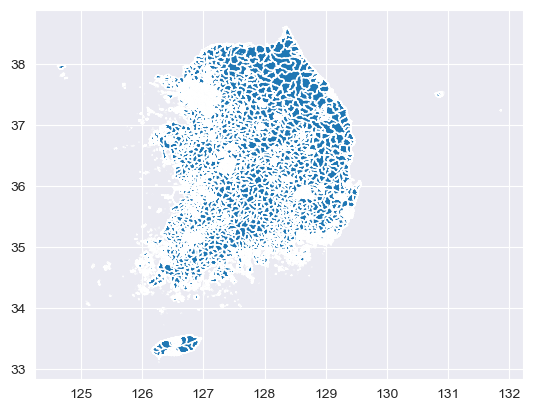

In [182]:
# geo pandas 요약 정보
gdf.info()
gdf.describe()
gdf.plot()

# 2. 더대시 데이터 셋에서 주차별, 동별 데이터 뽑아내기

In [188]:
df = pd.read_excel("../dataset/dataset.xlsx",sheet_name="Sheet2",header=1,index_col=False)
df = df.drop(columns=['Unnamed: 0','extra','startDate','endDate','createdAt'])
df = df.dropna(axis=0)

도 / 시, 군 / 동, 면, 읍 / 리, 지번 으로 파싱

In [189]:
# 함수 정의: 주소 파싱
def parse_address(location):
    # 시/도, 시/군/구, 읍/면/동, 도로명주소로 나누기
    parts = location.split()
    province = parts[0]
    if '시' in parts[1]:
        city = parts[1]
        district = parts[2]
        street = ' '.join(parts[3:])
    else:
        city = parts[1][:-1] + ' ' + parts[2]
        district = parts[3]
        street = ' '.join(parts[4:])
    return province, city, district, street


In [190]:

# split the 'Location' column into 'City' and 'State' columns
# 'Location' 열에서 'Province', 'City', 'District', 'Street' 열 추출하여 추가
df[['Province', 'City', 'District', 'Street']] = df['address'].apply(parse_address).apply(pd.Series)

# drop the original 'Location' column
df = df.drop('address', axis=1)


도 이름을 축약

In [191]:
province_names = {
    '경기도': '경기',
    '강원도': '강원',
    '충청북도': '충북',
    '충청남도': '충남',
    '전라북도': '전북',
    '전라남도': '전남',
    '경상북도': '경북',
    '경상남도': '경남',
}
df['Province'] = df['Province'].replace(province_names)

In [202]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111737 entries, 0 to 113039
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   geometry  111737 non-null  object 
 1   x         111737 non-null  float64
 2   y         111737 non-null  float64
 3   area      111737 non-null  float64
 4   TaskId    111737 non-null  int64  
 5   TeamId    111737 non-null  int64  
 6   Province  111737 non-null  object 
 7   City      111737 non-null  object 
 8   District  111737 non-null  object 
 9   Street    111737 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 9.4+ MB


,geometry,x,y,area,TaskId,TeamId,Province,City,District,Street
0,"{""type"":""MultiPolygon"",""coordinates"":[[[[128.6...",128.671277,36.480444,1992.0,618978,578,경북,안동시,일직면,구천리 364-4
1,"{""type"":""MultiPolygon"",""coordinates"":[[[[128.6...",128.673970,36.479439,1980.7,618978,578,경북,안동시,일직면,구천리 234-7
2,"{""type"":""MultiPolygon"",""coordinates"":[[[[128.6...",128.653249,36.484642,978.7,618978,578,경북,안동시,일직면,원호리 556
3,"{""type"":""MultiPolygon"",""coordinates"":[[[[128.6...",128.654980,36.470651,2598.7,618978,578,경북,안동시,일직면,운산리 64-100
4,"{""type"":""MultiPolygon"",""coordinates"":[[[[128.6...",128.670169,36.480552,2013.9,618978,578,경북,안동시,일직면,구천리 364-8


In [200]:
gdf.info()
gdf.head(5)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5189 entries, 0 to 5188
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   District  5189 non-null   object  
 1   WTK       5189 non-null   geometry
 2   Province  5189 non-null   object  
dtypes: geometry(1), object(2)
memory usage: 121.7+ KB


,District,WTK,Province
0,결성면,"POLYGON ((126.51586 36.52463, 126.51578 36.524...",충남
1,은하면,"MULTIPOLYGON (((126.61107 36.48282, 126.61100 ...",충남
2,장곡면,"POLYGON ((126.73953 36.54383, 126.73982 36.543...",충남
3,홍동면,"POLYGON ((126.73781 36.59067, 126.73825 36.590...",충남
4,금마면,"POLYGON ((126.73636 36.62769, 126.73636 36.627...",충남


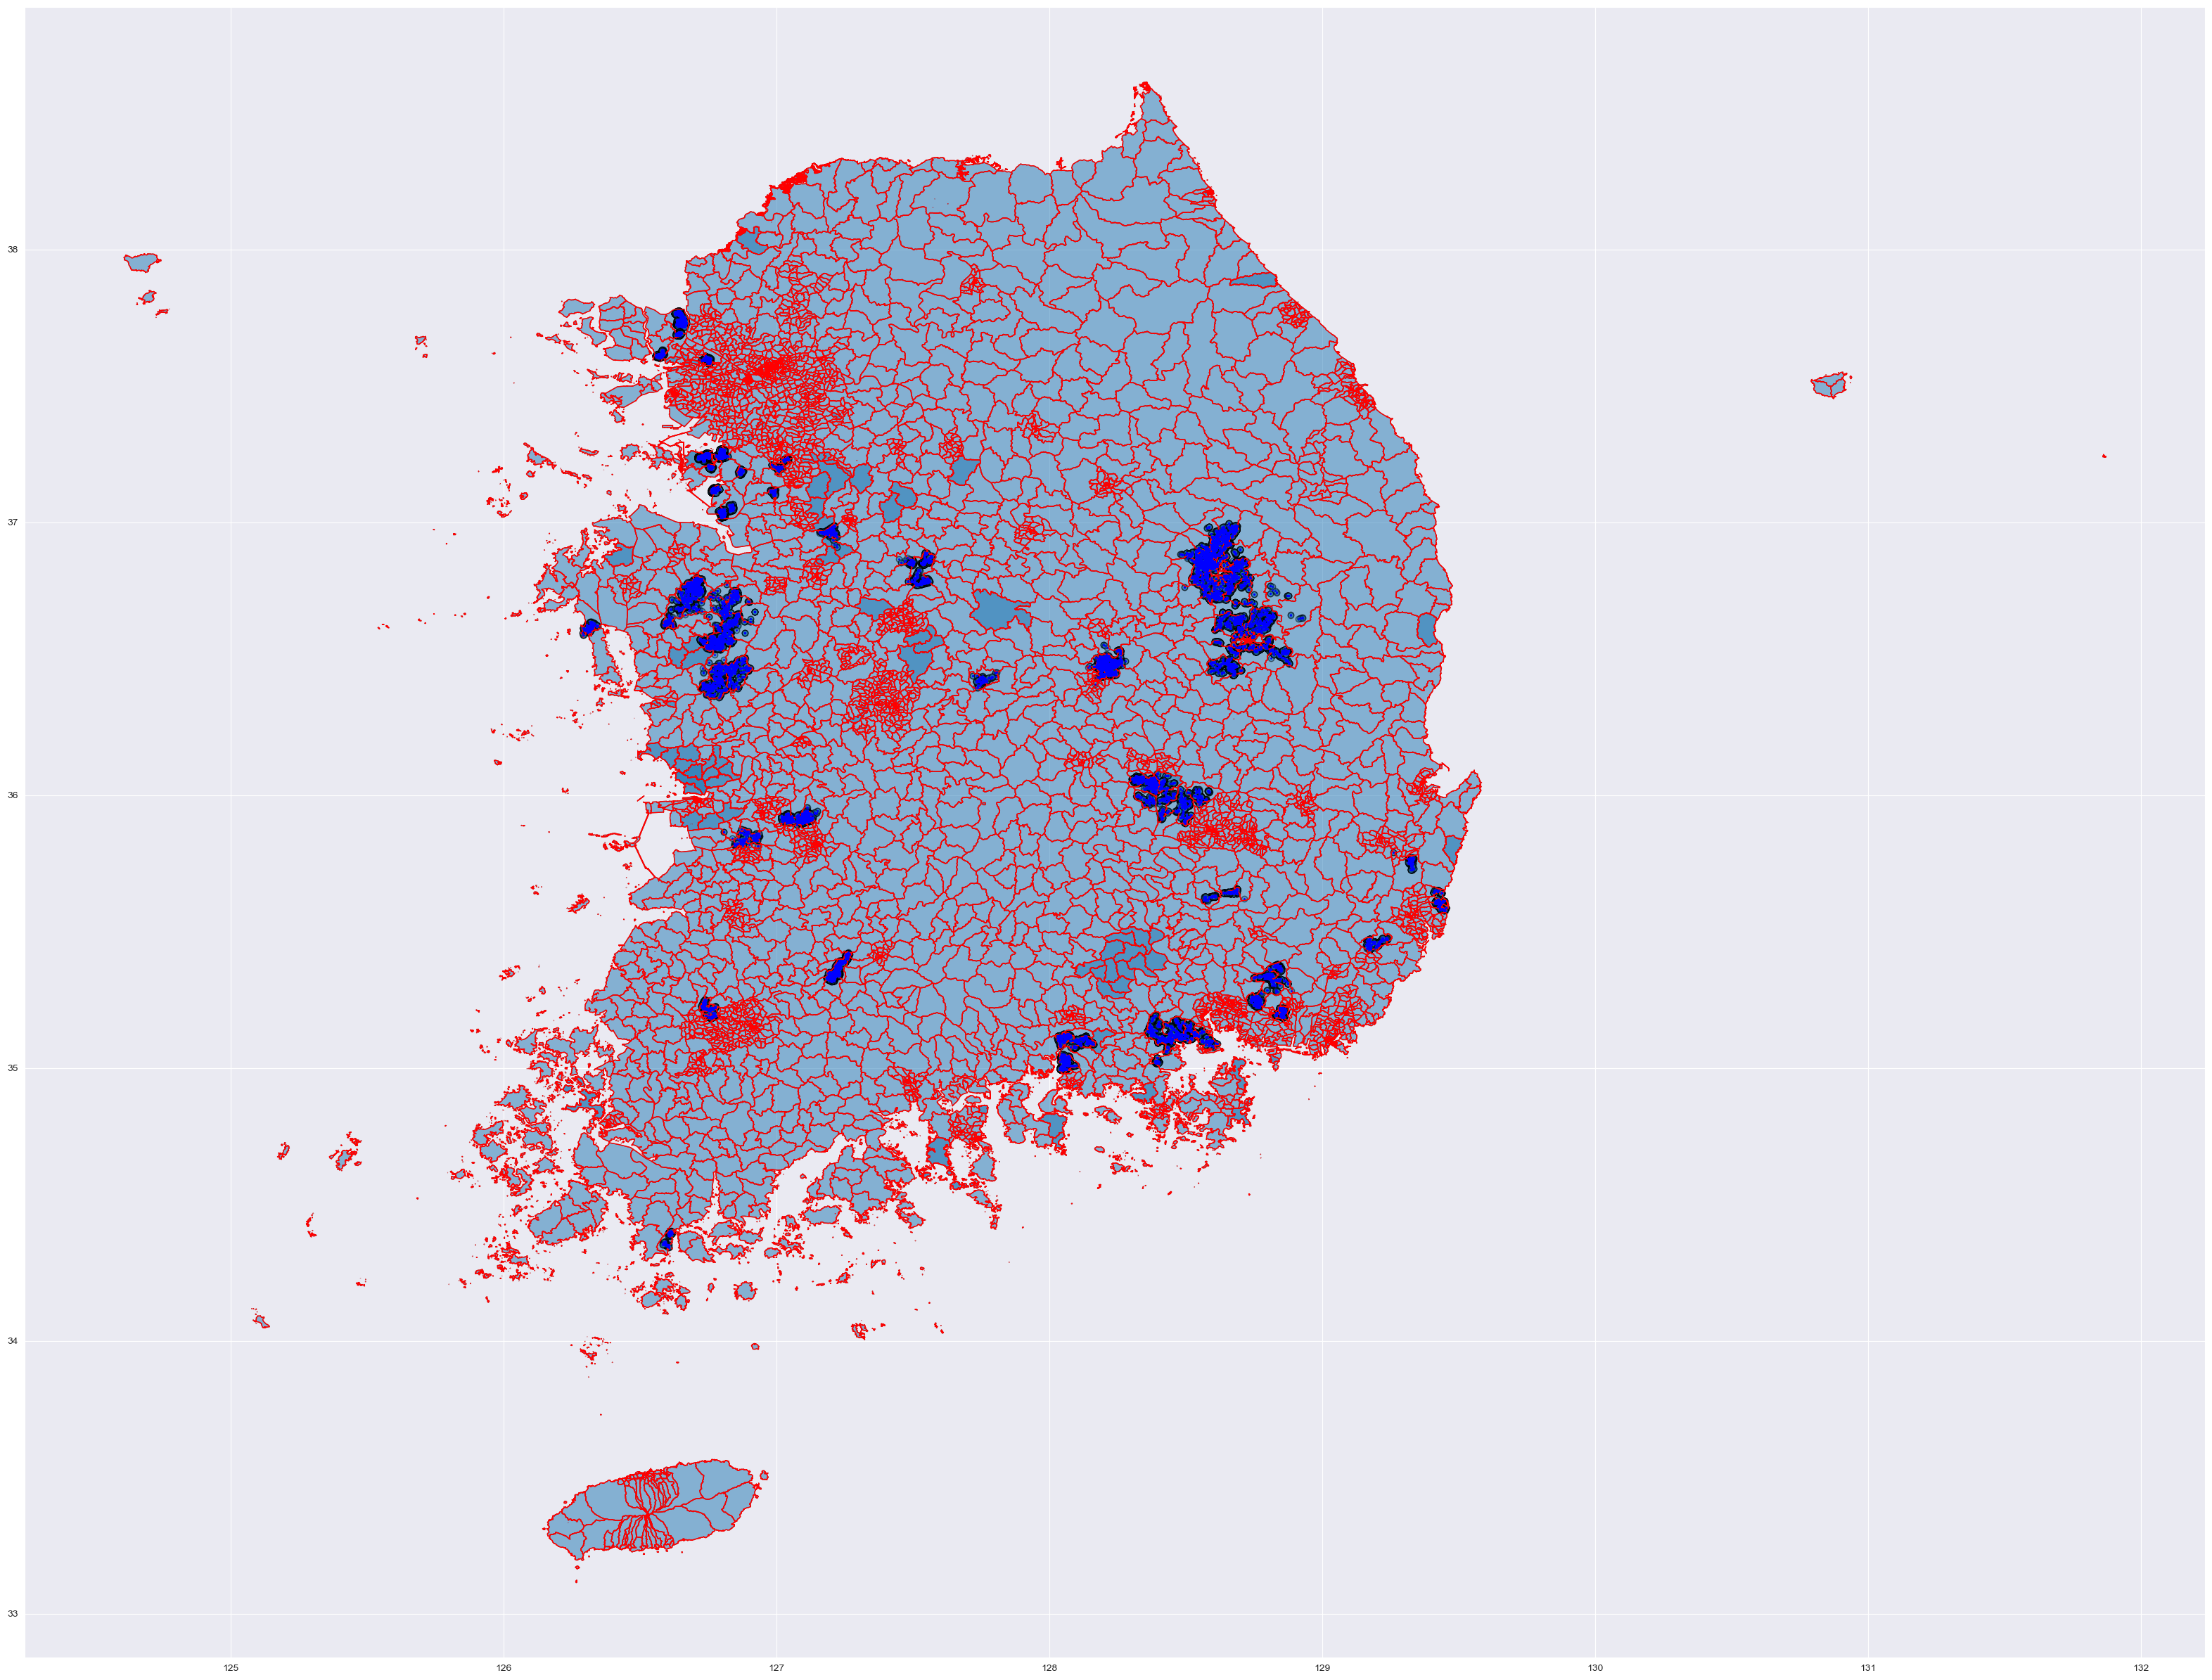

In [238]:
global_point_data = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.x,df.y))
global_district_and_point = gpd.GeoDataFrame(geometry=gdf.geometry.append(global_point_data.geometry))

# plot the GeoDataFrame
ax = global_district_and_point.plot(figsize=(40,40), alpha=0.5, edgecolor='k')
gdf.plot(ax=ax, facecolor='none', edgecolor='r')
global_point_data.plot(ax=ax, color='b', markersize=1)
plt.show()

Province와 District를 이용해, District plot

In [233]:
test_data = df.iloc[0][['Province','District','Street']]

local_district_data = gdf.loc[(gdf['Province']==test_data['Province'])]
local_district_data = local_district_data.loc[(local_district_data['District']==test_data['District'])]

     District                                                WTK Province
2494      일직면  POLYGON ((128.64356 36.51176, 128.64388 36.511...       경북


<AxesSubplot:>

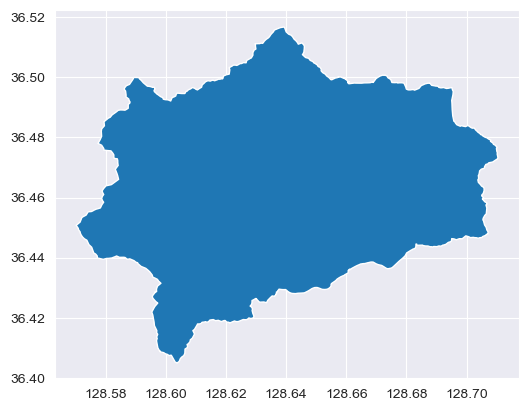

In [234]:
print(local_district_data)
local_district_data.plot()

District 지도 위에 토지 scatter

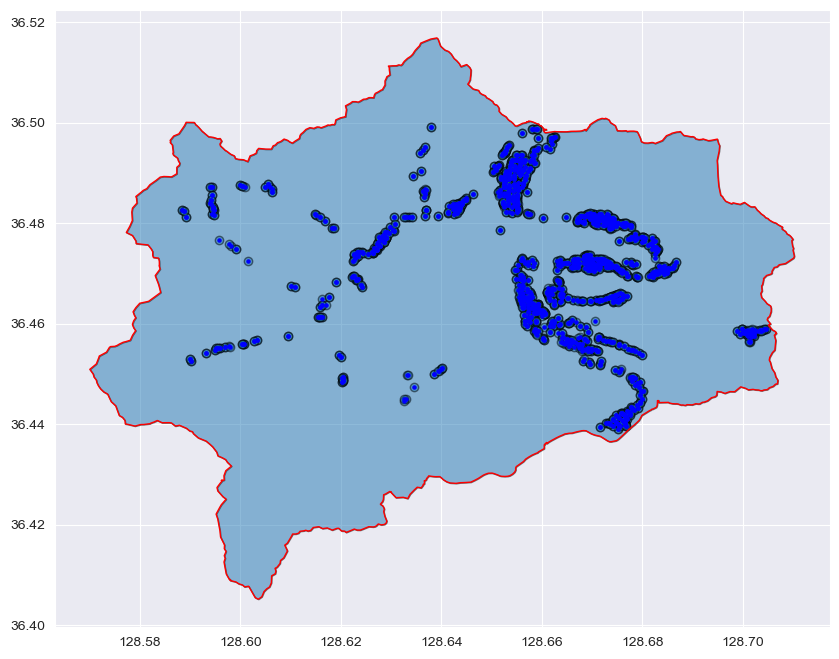

In [235]:
test_area = df.loc[df['District']==test_data['District']]
local_point_data = gpd.GeoDataFrame(geometry=gpd.points_from_xy(test_area.x,test_area.y))
local_district_and_point = gpd.GeoDataFrame(geometry=local_district_data.geometry.append(local_point_data.geometry))

# plot the GeoDataFrame
ax = local_district_and_point.plot(figsize=(10,10), alpha=0.5, edgecolor='k')
local_district_data.plot(ax=ax, facecolor='none', edgecolor='r')
local_point_data.plot(ax=ax, color='b', markersize=5)
plt.show()